In [1]:
"""This notebook generates figrue 3d,e,f for the MIST manuscript"""
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append("MIST/")
import utils
import numpy as np
from scipy.stats import spearmanr, pearsonr
from glob import glob
import math
from sklearn.preprocessing import RobustScaler,StandardScaler

# Function to plot the best performed gene in holdout experiments

In [16]:
def plot_gene_expr(data, meta, gene, ax, n_outlier=0,c=None):
    """Function to plot non-zero gene expression with outliers"""
    
    meta = meta.loc[data.index,:]
    f = plt.figure(figsize=(3,3))
    
    zero_inds = data.index[data[gene] == 0].to_numpy()
    nonzero_inds = data.index[data[gene] > 0].to_numpy()
    
    # remove outlier
    nonzero_expr = data.loc[nonzero_inds, gene].to_numpy()
    for i in range(n_outlier + 1):
        nonzero_expr = np.delete(nonzero_expr, np.argmin(nonzero_expr))
        nonzero_inds = np.delete(nonzero_inds, np.argmin(nonzero_expr))
    
    nonzero_expr = nonzero_expr.reshape(-1, 1)
    # z-score normalize
    transformer = StandardScaler().fit(nonzero_expr) 
    nonzero_expr = transformer.transform(nonzero_expr)[:,0]
    zero_meta = meta.loc[zero_inds,:]
    nonzero_meta = meta.loc[nonzero_inds,:]
    
    sizes = []
    
    vmin, vmax = np.min(nonzero_expr), np.max(nonzero_expr)
    # normalize size of expression values
    for v in nonzero_expr:
        s = 10 + 35 * (v-vmin)/(vmax-vmin)
        sizes.append(s)
    
    if c == None:
        p = ax.scatter(x=nonzero_meta.coordX.to_numpy(), 
                   y=nonzero_meta.coordY.to_numpy(),
                   c=nonzero_expr,s=sizes,
                   linewidth=0,  cmap='coolwarm')
        cbar = plt.colorbar(p, ax=ax)
    else:
        uniques, cvals = np.unique(meta[c].tolist(), return_inverse=True)
        p = ax.scatter(x=nonzero_meta.coordX.to_numpy(), 
                   y=nonzero_meta.coordY.to_numpy(),
                   c=cvals, s=sizes,
                   linewidth=0,  cmap='coolwarm')
        cbar = f.colorbar(p, cax=ax, boundaries=np.arange(-0.5, len(uniques)+0.5, 1))
        
    ax.scatter(x=zero_meta.coordX.to_numpy(),
               y=zero_meta.coordY.to_numpy(),
               s=5,c='black')
     

    plt.setp(ax, xticks=[], yticks=[])
    ax.invert_yaxis()
    plt.close()
    return f

def plot_top_gene():
    dns = ["MouseWT", "MouseAD", "Prostate", "Melanoma"]
    f, axs = plt.subplots(ncols=5, nrows=4, figsize=(20,12))
    
    for i in range(4):
        # PLOT one example gene for each sample
        dn = dns[i]
        gene_df = pd.read_csv("data/%s/performance/gene_level_results.csv" %dn)
        # Sort by MIST PCC
        gene_df = gene_df.loc[gene_df.model == "MIST",:] 
        gene_df = gene_df.sort_values("pcc", ascending=False)
        gene = gene_df.gene.tolist()[0]
        
        if dn == "Melanoma":
            gene = "GAPDH ENSG00000111640"
            
        gene_name = gene.split()[0]
        ## READ and process data
        fd = gene_df.cvFold.tolist()[0]
        ori, df = utils.read_ST_data("data/%s/norm.csv" %dn)
        mist_fn = glob("data/%s/MIST_*_%d.csv" %(dn, fd))[0] # get mist imputed file name
        sp, _ = utils.read_ST_data(mist_fn) # read imputed data
        ho, _ = utils.read_ST_data("data/%s/ho_data_%d.csv" %(dn, fd)) # read holdout data
        # normalize data
        ori = np.log2(ori + 1)
        sp = np.log2(sp + 1)
        ho = np.log2(ho + 1)
        sp = sp.loc[ori.index,:]
        ho = ho.loc[ori.index,:]

        df["observed"] = ori[gene].to_numpy()
        df["hold out"] = ho[gene].to_numpy()
        df["MIST"] = sp[gene].to_numpy()
        
        # Calculate PCC and SCC between ground truth and holdout and MIST imputed values
        pcc_ho = (pearsonr(df["observed"].to_numpy(), df["hold out"]))[0]
        pcc_imp = (pearsonr(df["observed"].to_numpy(), df["MIST"]))[0]
        scc_ho = (spearmanr(df["observed"].to_numpy(), df["hold out"]))[0]
        scc_imp = (spearmanr(df["observed"].to_numpy(), df["MIST"]))[0]

        mask = pd.read_csv("data/%s/ho_mask_%d.csv" %(dn, fd), index_col=0)
        mask_spots = mask.index[mask[gene] == 1].tolist()

        mask_df = df.loc[df.index.isin(mask_spots),:]
        ho_df = df.loc[~df.index.isin(mask_spots),:]
        
        # plot gene expression with holdout events
        plot_gene_expr(df, df, 'hold out', axs[i,0])
        axs[i,0].text(-0.2,.2,"%s\n(%s)" %(dn, gene_name), fontsize=15,
        horizontalalignment='center',rotation=90,
        transform=axs[i,0].transAxes)
        # plot gene expression with MIST estimated holdout values
        plot_gene_expr(df, df, 'MIST', axs[i,1])
        # plot gene expression with ground truth values
        plot_gene_expr(df, df, 'observed', axs[i,2])
        
        ## FIGURE 3E
        axs[i,3].scatter(y=df["observed"], x=df["hold out"], color="blue", edgecolor="lightgray")
        axs[i,3].set_xlabel("Input value", fontsize=15)
        axs[i,3].set_ylabel("Observed value", fontsize=15)
        axs[i,3].text(.5,.9,"PCC=%.2f, SCC=%.2f" %(pcc_ho, scc_ho),fontsize=14,
        horizontalalignment='center',
        transform=axs[i,3].transAxes)
    
        xint1 = np.arange(math.floor(min(df["hold out"])), math.ceil(max(df["hold out"]))+3, 4)
        yint1 = np.arange(math.floor(min(df["observed"])), math.ceil(max(df["observed"]))+2, 2)
        axs[i,3].set_yticks(xint1)
        axs[i,3].set_xticks(xint1)
        
        axs[i,3].set_ylim(ymax=max(df["observed"]) + 2)
        axs[i,3].tick_params(axis="both", length=0, width=0)
        ## FIGURE 3F
        axs[i,4].scatter(y=df["observed"], x=df["MIST"], color="blue", edgecolor="lightgray")
        # make the scale of x,y axis consistent
        yint2 = np.arange(math.floor(min(df["observed"])), math.ceil(max(df["observed"]))+2, 2) 
        xint2 = np.arange(math.floor(min(df["MIST"])), math.ceil(max(df["MIST"]))+2, 2)
        axs[i,4].set_yticks(yint2)
        axs[i,4].set_xticks(yint2)
        axs[i,4].set_ylabel("")
        axs[i,4].set_xlabel("Imputed value", fontsize=15)
        axs[i,4].set_ylim(ymax=max(df["MIST"]) + 2)
        if i in range(3):
            axs[i,3].set_xlabel("")
            axs[i,4].set_xlabel("")
            
        axs[i,4].text(.5,.9,"PCC=%.2f, SCC=%.2F" %(pcc_imp, scc_imp),fontsize=14,
        horizontalalignment='center',
        transform=axs[i,4].transAxes)
        axs[i,4].tick_params(axis="both", length=0, width=0)
    for j in range(3):
        axs[0,j].set_title(["Input", "Imputed", "Observed"][j], fontsize=16)
        
    
    plt.subplots_adjust(wspace=0.3, hspace=0.1)
#     plt.savefig("Figures/ExtFig3-3.png", dpi=300,bbox_inches="tight")
#     plt.close()

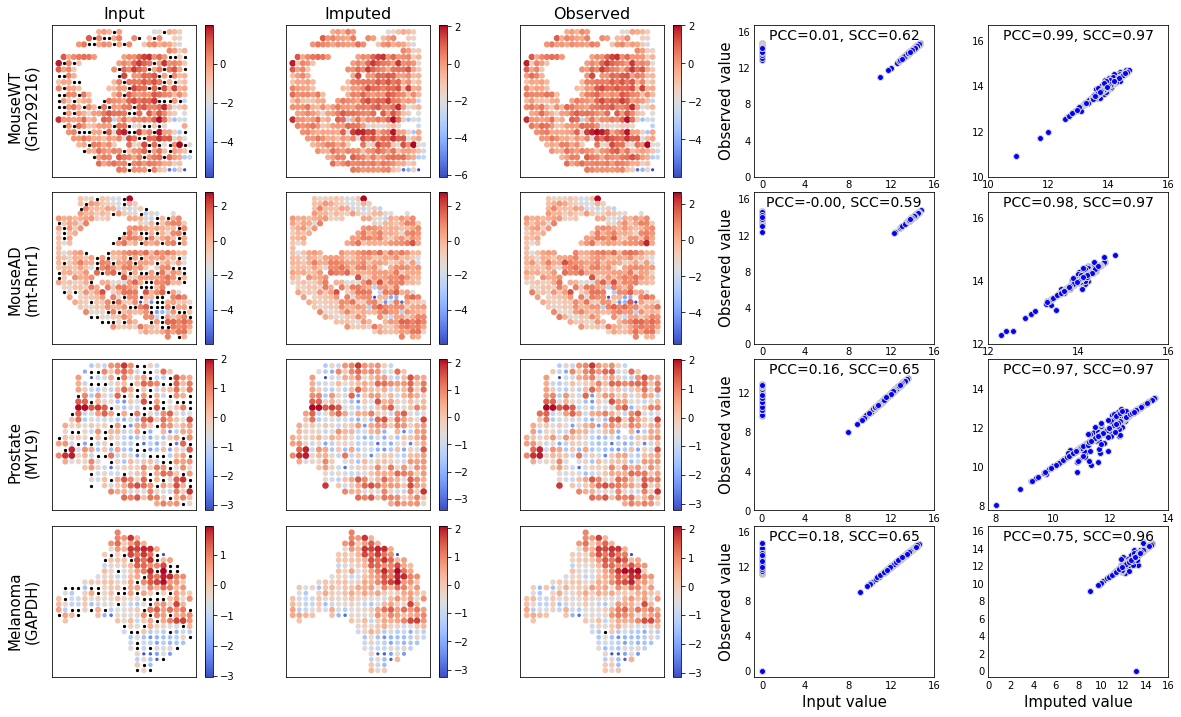

In [17]:
plot_top_gene()